Use Python to fetch XAUUSDc H1 candles data from MT5.  Add a signal logic: Starts calculating exactly at 0:00am UTC, If the corresponding candle's tick-volume bar 'position =0' is lower than 'position = -1' and  "'position = -1' is higher than 'position = -2'  and 'position = 0' ", then highlight the coresponding candle red of bulish and blue if bullish. Use plotly white themed.

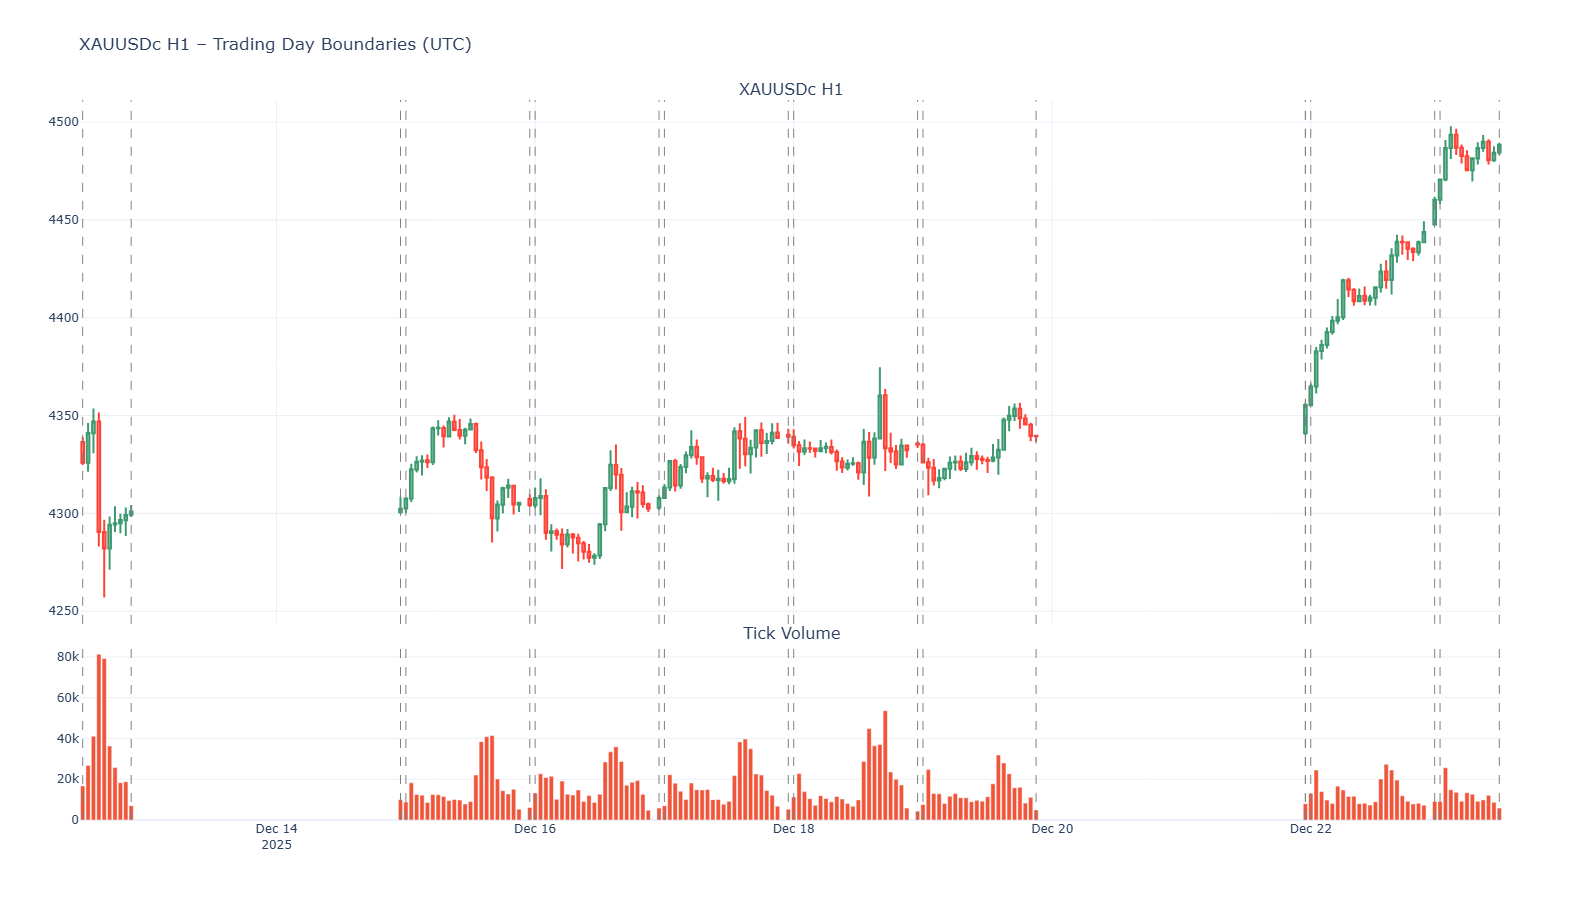

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
lookback_days = 10
utc_timezone = pytz.UTC

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(
    symbol,
    timeframe,
    utc_from,
    utc_now
)

mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS
# -------------------------------------------------
df["trade_date"] = df.index.date

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("trade_date", lambda x: x.index.min()),
        last_time=("trade_date", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# PLOTLY FIGURE (2 PANES)
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=("XAUUSDc H1", "Tick Volume")
)

# -------------------------------------------------
# CANDLESTICKS
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(
        x=row["first_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )
    fig.add_vline(
        x=row["last_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title="XAUUSDc H1 – Trading Day Boundaries (UTC)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=False,
    template="plotly_white",
)

fig.show()


scan start at 0:00.
define tv as tick-volume.
locate the very first pattern (made of three tv values).
If the current "candle's (position = 0) tv" is < "candle's (position = -1) tv" and "candle's (position = -1) tv" is > "candle's (position = 0) tv" and "candle's (position = -2) tv", then mark the current candle as violet if the candlestick is bearish and blue if the candlestick is bullish.

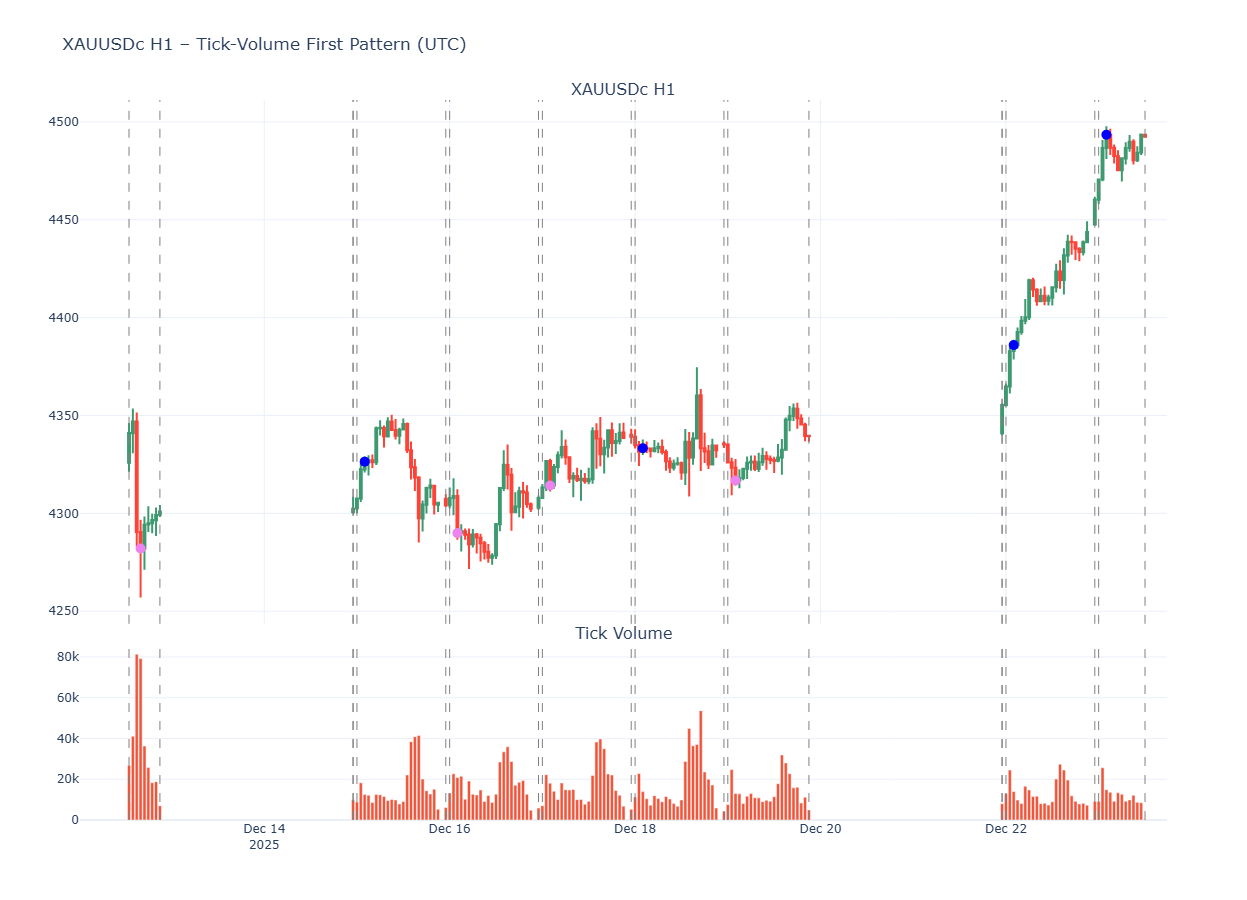

In [6]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
lookback_days = 10
utc_timezone = pytz.UTC

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS (UTC 00:00 START)
# -------------------------------------------------
df["trade_date"] = df.index.normalize()

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("open", lambda x: x.index.min()),
        last_time=("open", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# FIRST TICK-VOLUME PATTERN PER DAY
# -------------------------------------------------
pattern_marks = []

for trade_date, day_df in df.groupby("trade_date"):
    day_df = day_df.sort_index()

    found = False
    for i in range(2, len(day_df)):
        tv_0 = day_df.iloc[i]["tick_volume"]
        tv_1 = day_df.iloc[i - 1]["tick_volume"]
        tv_2 = day_df.iloc[i - 2]["tick_volume"]

        if tv_0 < tv_1 and tv_1 > tv_2:
            candle = day_df.iloc[i]
            is_bullish = candle["close"] > candle["open"]

            pattern_marks.append({
                "time": candle.name,
                "price": candle["close"],
                "color": "blue" if is_bullish else "violet"
            })
            found = True
            break

# -------------------------------------------------
# PLOTLY FIGURE (2 PANES)
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=("XAUUSDc H1", "Tick Volume")
)

# -------------------------------------------------
# CANDLESTICKS
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME (tv)
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# PATTERN MARKERS
# -------------------------------------------------
if pattern_marks:
    fig.add_trace(
        go.Scatter(
            x=[m["time"] for m in pattern_marks],
            y=[m["price"] for m in pattern_marks],
            mode="markers",
            marker=dict(
                size=10,
                color=[m["color"] for m in pattern_marks]
            ),
            name="TV Pattern"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(
        x=row["first_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )
    fig.add_vline(
        x=row["last_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title="XAUUSDc H1 – Tick-Volume First Pattern (UTC)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=False,
    template="plotly_white"
)

fig.show()


In [ ]:
make an RSI indicator that starts and end at the same trading day 

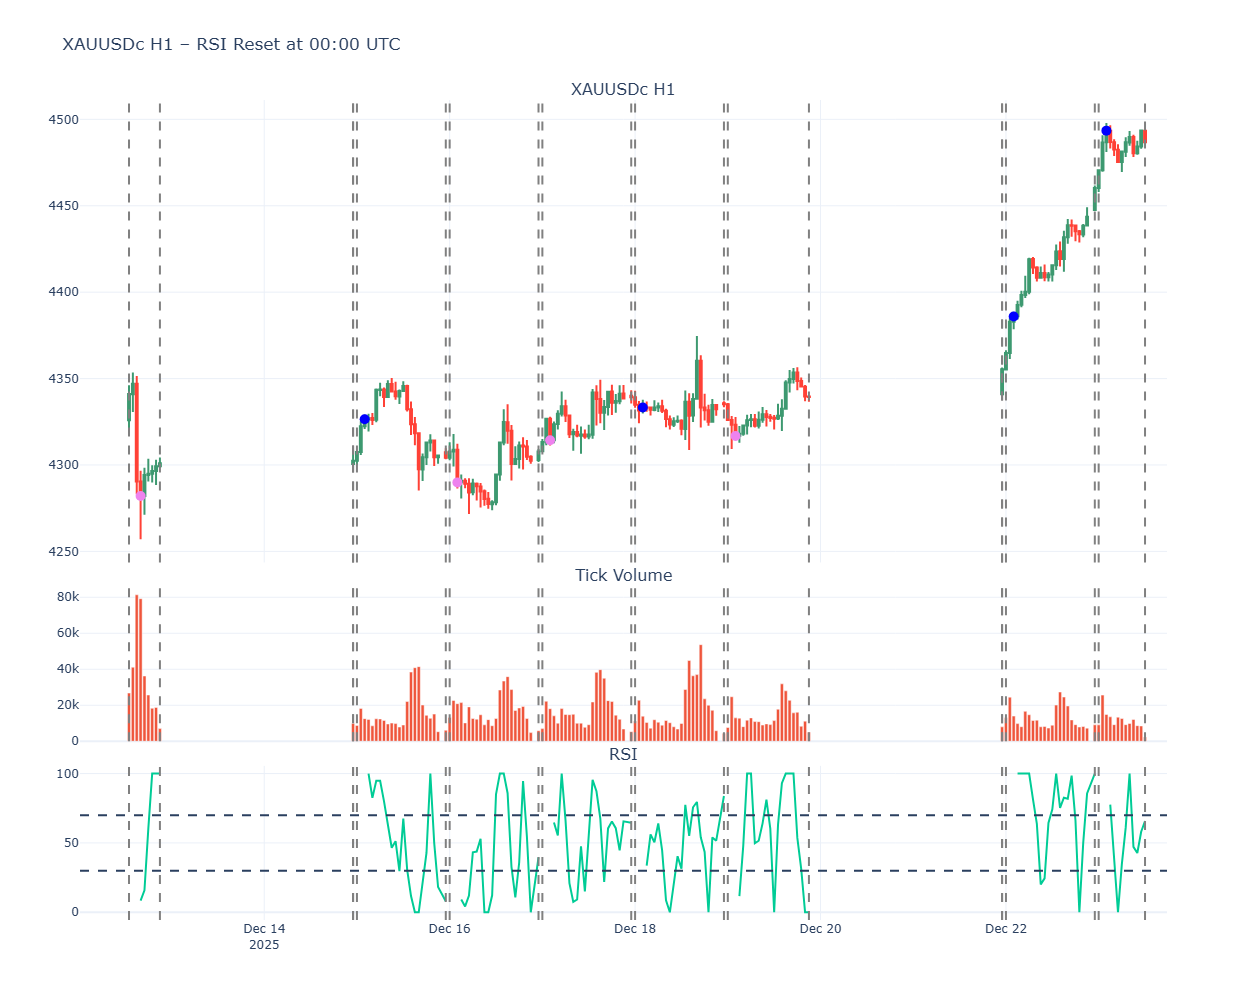

In [19]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -----------------------------
# PARAMETERS
# -----------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
lookback_days = 10
rsi_length = 3
utc_timezone = pytz.UTC

# -----------------------------
# INITIALIZE MT5
# -----------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")
if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -----------------------------
# FETCH DATA
# -----------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -----------------------------
# TRADING DAY (RESET RSI AT 00:00 UTC)
# -----------------------------
df["trade_date"] = df.index.normalize()  # midnight UTC

# -----------------------------
# DAILY RESET RSI
# -----------------------------
df["rsi"] = pd.NA

for trade_date, day_df in df.groupby("trade_date"):
    closes = day_df["close"]
    delta = closes.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(rsi_length, min_periods=rsi_length).mean()
    avg_loss = loss.rolling(rsi_length, min_periods=rsi_length).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df.loc[day_df.index, "rsi"] = rsi

# -----------------------------
# DAILY FIRST / LAST CANDLE
# -----------------------------
daily_bounds = df.groupby("trade_date").agg(
    first_time=("open", lambda x: x.index.min()),
    last_time=("open", lambda x: x.index.max())
)

# -----------------------------
# FIRST TICK-VOLUME PATTERN PER DAY
# -----------------------------
pattern_marks = []

for trade_date, day_df in df.groupby("trade_date"):
    day_df = day_df.sort_index()
    for i in range(2, len(day_df)):
        tv0 = day_df.iloc[i]["tick_volume"]
        tv1 = day_df.iloc[i - 1]["tick_volume"]
        tv2 = day_df.iloc[i - 2]["tick_volume"]

        if tv0 < tv1 and tv1 > tv2:
            candle = day_df.iloc[i]
            bullish = candle["close"] > candle["open"]
            pattern_marks.append({
                "time": candle.name,
                "price": candle["close"],
                "color": "blue" if bullish else "violet"
            })
            break

# -----------------------------
# PLOTLY FIGURE (3 PANES)
# -----------------------------
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.6, 0.2, 0.2],
    subplot_titles=("XAUUSDc H1", "Tick Volume", "RSI")
)

# -----------------------------
# CANDLES
# -----------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index, open=df["open"], high=df["high"], low=df["low"], close=df["close"]
    ),
    row=1, col=1
)

# -----------------------------
# Tick Volume
# -----------------------------
fig.add_trace(
    go.Bar(x=df.index, y=df["tick_volume"], name="Tick Volume"),
    row=2, col=1
)

# -----------------------------
# RSI
# -----------------------------
fig.add_trace(
    go.Scatter(x=df.index, y=df["rsi"], mode="lines", name="RSI"),
    row=3, col=1
)
fig.add_hline(y=70, line_dash="dash", row=3, col=1)
fig.add_hline(y=30, line_dash="dash", row=3, col=1)

# -----------------------------
# Pattern markers
# -----------------------------
if pattern_marks:
    fig.add_trace(
        go.Scatter(
            x=[m["time"] for m in pattern_marks],
            y=[m["price"] for m in pattern_marks],
            mode="markers",
            marker=dict(size=10, color=[m["color"] for m in pattern_marks]),
            name="TV Pattern"
        ),
        row=1, col=1
    )

# -----------------------------
# Daily vertical lines
# -----------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(x=row["first_time"], line_dash="dash", line_color="gray")
    fig.add_vline(x=row["last_time"], line_dash="dash", line_color="gray")

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    title="XAUUSDc H1 – RSI Reset at 00:00 UTC",
    height=1000,
    xaxis_rangeslider_visible=False,
    showlegend=False,
    template="plotly_white"
)

fig.show()


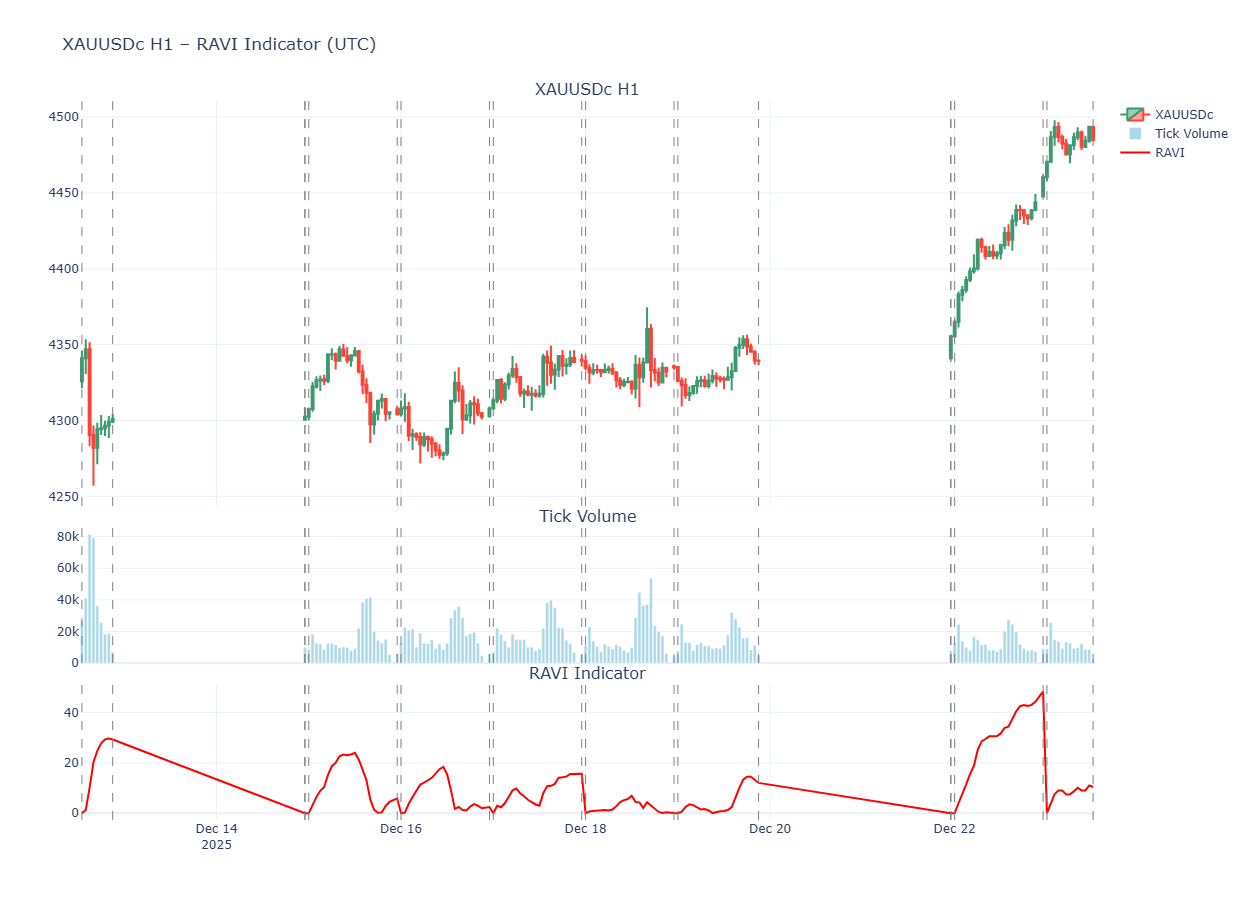

In [20]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
lookback_days = 10
utc_timezone = pytz.UTC

fast_len = 7   # EMA short period
slow_len = 65  # EMA long period

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS (UTC 00:00 START)
# -------------------------------------------------
df["trade_date"] = df.index.normalize()

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("open", lambda x: x.index.min()),
        last_time=("open", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# CALCULATE RAVI PER DAY
# -------------------------------------------------
ravi_list = []

for trade_date, day_df in df.groupby("trade_date"):
    day_df = day_df.sort_index()
    close = day_df["close"]

    # Calculate EMAs for the day
    ema_fast = close.ewm(span=fast_len, adjust=False).mean()
    ema_slow = close.ewm(span=slow_len, adjust=False).mean()
    
    # RAVI = |Fast EMA - Slow EMA|
    ravi = (ema_fast - ema_slow).abs()
    
    day_ravi = pd.DataFrame({
        "time": day_df.index,
        "ravi": ravi
    })
    ravi_list.append(day_ravi)

ravi_df = pd.concat(ravi_list).set_index("time")

# -------------------------------------------------
# PLOTLY FIGURE (3 PANES: Price, Tick Volume, RAVI)
# -------------------------------------------------
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.6, 0.2, 0.2],
    subplot_titles=("XAUUSDc H1", "Tick Volume", "RAVI Indicator")
)

# -------------------------------------------------
# CANDLESTICKS
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume",
        marker_color="lightblue"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# RAVI
# -------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=ravi_df.index,
        y=ravi_df["ravi"],
        mode="lines",
        line=dict(color="red"),
        name="RAVI"
    ),
    row=3,
    col=1
)

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(x=row["first_time"], line_width=1, line_dash="dash", line_color="gray")
    fig.add_vline(x=row["last_time"], line_width=1, line_dash="dash", line_color="gray")

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title="XAUUSDc H1 – RAVI Indicator (UTC)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


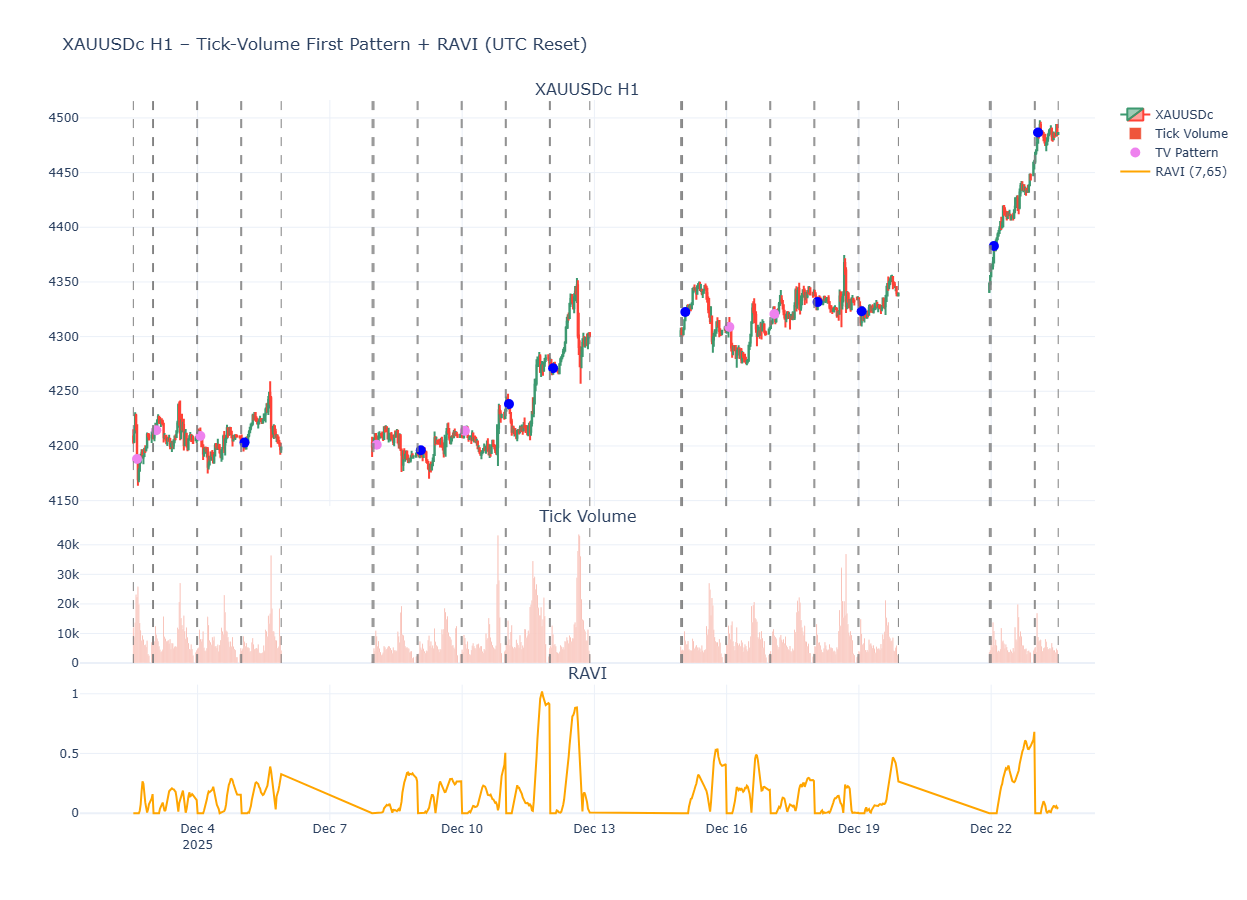

In [24]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M30
lookback_days = 20
utc_timezone = pytz.UTC
ravi_short_period = 7   # Short MA period
ravi_long_period = 65   # Long MA period

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS (UTC 00:00 START)
# -------------------------------------------------
df["trade_date"] = df.index.normalize()

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("open", lambda x: x.index.min()),
        last_time=("open", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# FIRST TICK-VOLUME PATTERN PER DAY
# -------------------------------------------------
pattern_marks = []

for trade_date, day_df in df.groupby("trade_date"):
    day_df = day_df.sort_index()

    found = False
    for i in range(2, len(day_df)):
        tv_0 = day_df.iloc[i]["tick_volume"]
        tv_1 = day_df.iloc[i - 1]["tick_volume"]
        tv_2 = day_df.iloc[i - 2]["tick_volume"]

        if tv_0 < tv_1 and tv_1 > tv_2:
            candle = day_df.iloc[i]
            is_bullish = candle["close"] > candle["open"]

            pattern_marks.append({
                "time": candle.name,
                "price": candle["close"],
                "color": "blue" if is_bullish else "violet"
            })
            found = True
            break

# -------------------------------------------------
# RAVI CALCULATION (Daily Reset)
# -------------------------------------------------
df["ravi"] = None
for trade_date, day_df in df.groupby("trade_date"):
    close_prices = day_df["close"]
    short_ma = close_prices.rolling(ravi_short_period, min_periods=1).mean()
    long_ma = close_prices.rolling(ravi_long_period, min_periods=1).mean()
    ravi_values = ((short_ma - long_ma).abs() / long_ma) * 100
    df.loc[day_df.index, "ravi"] = ravi_values

# -------------------------------------------------
# PLOTLY FIGURE (3 PANES: Price, Tick Volume, RAVI)
# -------------------------------------------------
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.6, 0.2, 0.2],
    subplot_titles=("XAUUSDc H1", "Tick Volume", "RAVI")
)

# -------------------------------------------------
# CANDLESTICKS
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# PATTERN MARKERS
# -------------------------------------------------
if pattern_marks:
    fig.add_trace(
        go.Scatter(
            x=[m["time"] for m in pattern_marks],
            y=[m["price"] for m in pattern_marks],
            mode="markers",
            marker=dict(
                size=10,
                color=[m["color"] for m in pattern_marks]
            ),
            name="TV Pattern"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(
        x=row["first_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )
    fig.add_vline(
        x=row["last_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

# -------------------------------------------------
# RAVI LINE
# -------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["ravi"],
        mode="lines",
        line=dict(color="orange"),
        name=f"RAVI ({ravi_short_period},{ravi_long_period})"
    ),
    row=3,
    col=1
)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"XAUUSDc H1 – Tick-Volume First Pattern + RAVI (UTC Reset)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


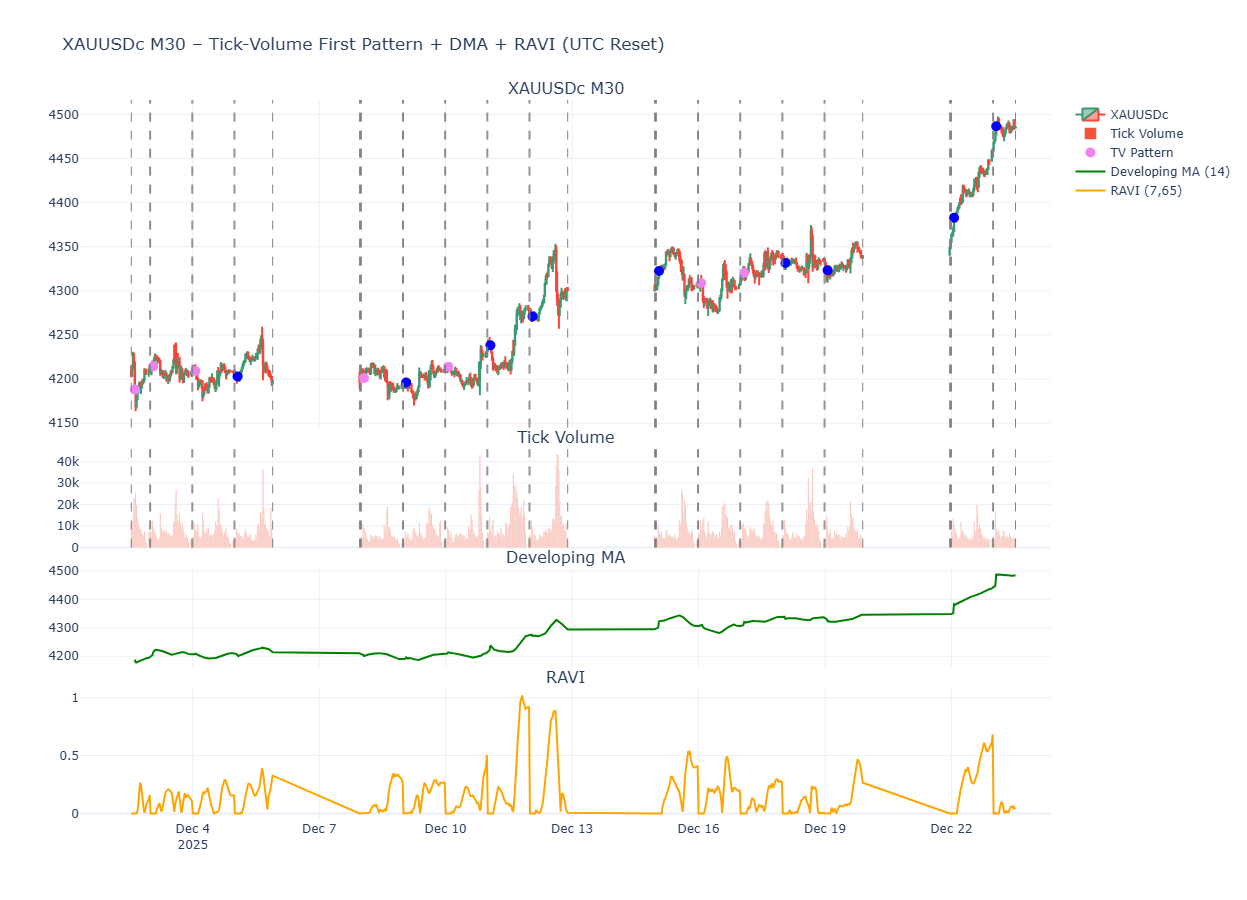

In [25]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M30
lookback_days = 20
utc_timezone = pytz.UTC
ravi_short_period = 7
ravi_long_period = 65
dma_period = 14  # Developing MA period

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS (UTC 00:00 START)
# -------------------------------------------------
df["trade_date"] = df.index.normalize()

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("open", lambda x: x.index.min()),
        last_time=("open", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# FIRST TICK-VOLUME PATTERN PER DAY
# -------------------------------------------------
pattern_marks = []
signal_indices = []

for trade_date, day_df in df.groupby("trade_date"):
    day_df = day_df.sort_index()

    for i in range(2, len(day_df)):
        tv_0 = day_df.iloc[i]["tick_volume"]
        tv_1 = day_df.iloc[i - 1]["tick_volume"]
        tv_2 = day_df.iloc[i - 2]["tick_volume"]

        if tv_0 < tv_1 and tv_1 > tv_2:
            candle = day_df.iloc[i]
            is_bullish = candle["close"] > candle["open"]

            pattern_marks.append({
                "time": candle.name,
                "price": candle["close"],
                "color": "blue" if is_bullish else "violet"
            })
            signal_indices.append(candle.name)
            break

# -------------------------------------------------
# DEVELOPING MOVING AVERAGE (DMA)
# -------------------------------------------------
df["dma"] = None

if signal_indices:
    for start, end in zip(signal_indices, signal_indices[1:] + [df.index[-1]]):
        dma_slice = df.loc[start:end]["close"].copy()
        dma_slice = dma_slice.rolling(dma_period, min_periods=1).mean()
        df.loc[start:end, "dma"] = dma_slice

# -------------------------------------------------
# RAVI CALCULATION (Daily Reset)
# -------------------------------------------------
df["ravi"] = None
for trade_date, day_df in df.groupby("trade_date"):
    close_prices = day_df["close"]
    short_ma = close_prices.rolling(ravi_short_period, min_periods=1).mean()
    long_ma = close_prices.rolling(ravi_long_period, min_periods=1).mean()
    ravi_values = ((short_ma - long_ma).abs() / long_ma) * 100
    df.loc[day_df.index, "ravi"] = ravi_values

# -------------------------------------------------
# PLOTLY FIGURE (4 PANES: Price, Tick Volume, DMA, RAVI)
# -------------------------------------------------
fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.5, 0.15, 0.15, 0.2],
    subplot_titles=("XAUUSDc M30", "Tick Volume", "Developing MA", "RAVI")
)

# -------------------------------------------------
# CANDLESTICKS
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# PATTERN MARKERS
# -------------------------------------------------
if pattern_marks:
    fig.add_trace(
        go.Scatter(
            x=[m["time"] for m in pattern_marks],
            y=[m["price"] for m in pattern_marks],
            mode="markers",
            marker=dict(
                size=10,
                color=[m["color"] for m in pattern_marks]
            ),
            name="TV Pattern"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(
        x=row["first_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )
    fig.add_vline(
        x=row["last_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

# -------------------------------------------------
# DEVELOPING MA LINE
# -------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["dma"],
        mode="lines",
        line=dict(color="green"),
        name=f"Developing MA ({dma_period})"
    ),
    row=3,
    col=1
)

# -------------------------------------------------
# RAVI LINE
# -------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["ravi"],
        mode="lines",
        line=dict(color="orange"),
        name=f"RAVI ({ravi_short_period},{ravi_long_period})"
    ),
    row=4,
    col=1
)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"XAUUSDc M30 – Tick-Volume First Pattern + DMA + RAVI (UTC Reset)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


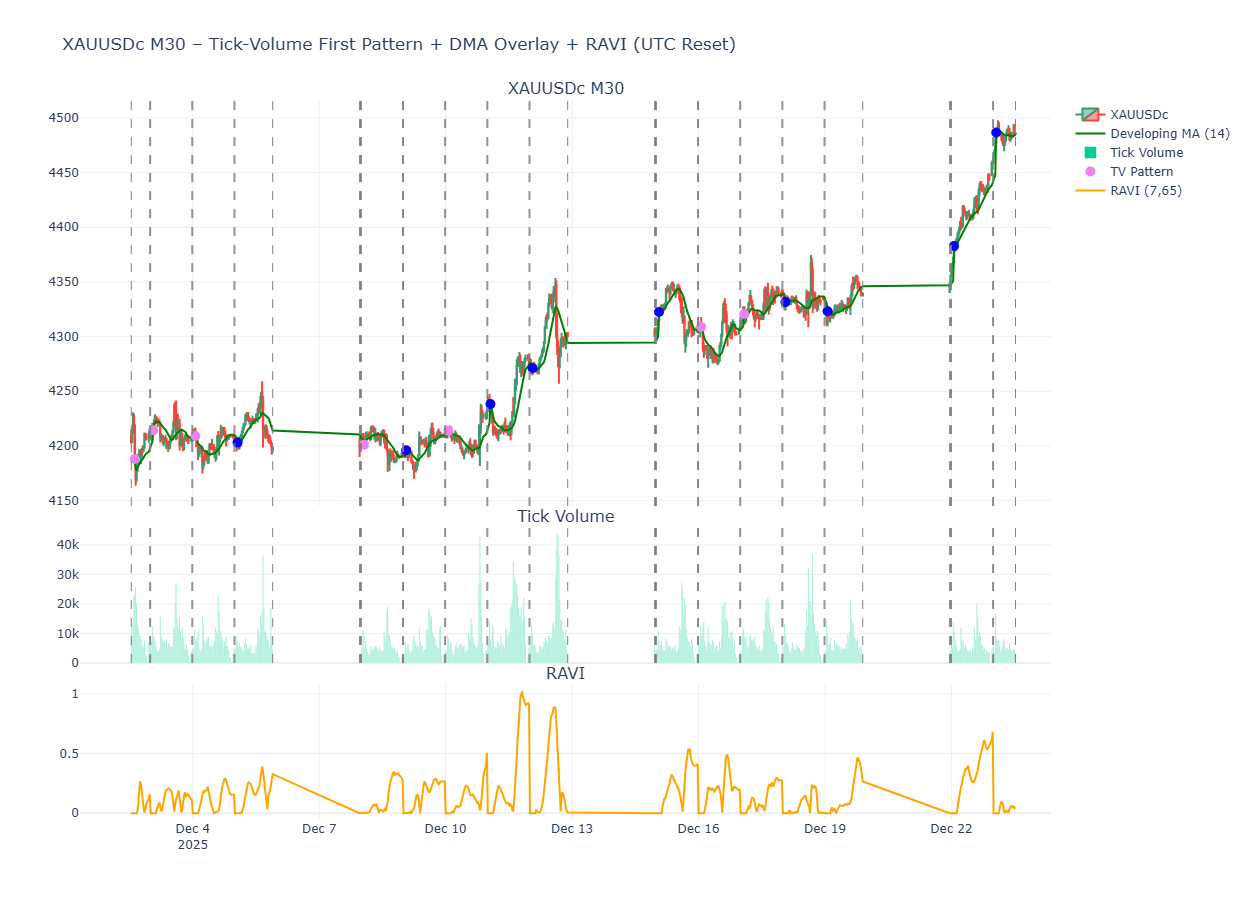

In [26]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M30
lookback_days = 20
utc_timezone = pytz.UTC
ravi_short_period = 7
ravi_long_period = 65
dma_period = 14  # Developing MA period

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS (UTC 00:00 START)
# -------------------------------------------------
df["trade_date"] = df.index.normalize()

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("open", lambda x: x.index.min()),
        last_time=("open", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# FIRST TICK-VOLUME PATTERN PER DAY
# -------------------------------------------------
pattern_marks = []
signal_indices = []

for trade_date, day_df in df.groupby("trade_date"):
    day_df = day_df.sort_index()

    for i in range(2, len(day_df)):
        tv_0 = day_df.iloc[i]["tick_volume"]
        tv_1 = day_df.iloc[i - 1]["tick_volume"]
        tv_2 = day_df.iloc[i - 2]["tick_volume"]

        if tv_0 < tv_1 and tv_1 > tv_2:
            candle = day_df.iloc[i]
            is_bullish = candle["close"] > candle["open"]

            pattern_marks.append({
                "time": candle.name,
                "price": candle["close"],
                "color": "blue" if is_bullish else "violet"
            })
            signal_indices.append(candle.name)
            break

# -------------------------------------------------
# DEVELOPING MOVING AVERAGE (DMA)
# -------------------------------------------------
df["dma"] = None
if signal_indices:
    for start, end in zip(signal_indices, signal_indices[1:] + [df.index[-1]]):
        dma_slice = df.loc[start:end]["close"].copy()
        dma_slice = dma_slice.rolling(dma_period, min_periods=1).mean()
        df.loc[start:end, "dma"] = dma_slice

# -------------------------------------------------
# RAVI CALCULATION (Daily Reset)
# -------------------------------------------------
df["ravi"] = None
for trade_date, day_df in df.groupby("trade_date"):
    close_prices = day_df["close"]
    short_ma = close_prices.rolling(ravi_short_period, min_periods=1).mean()
    long_ma = close_prices.rolling(ravi_long_period, min_periods=1).mean()
    ravi_values = ((short_ma - long_ma).abs() / long_ma) * 100
    df.loc[day_df.index, "ravi"] = ravi_values

# -------------------------------------------------
# PLOTLY FIGURE (3 PANES: Price with DMA, Tick Volume, RAVI)
# -------------------------------------------------
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.6, 0.2, 0.2],
    subplot_titles=("XAUUSDc M30", "Tick Volume", "RAVI")
)

# -------------------------------------------------
# CANDLESTICKS + DMA
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# DMA overlay on candlesticks
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["dma"],
        mode="lines",
        line=dict(color="green", width=2),
        name=f"Developing MA ({dma_period})"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# PATTERN MARKERS
# -------------------------------------------------
if pattern_marks:
    fig.add_trace(
        go.Scatter(
            x=[m["time"] for m in pattern_marks],
            y=[m["price"] for m in pattern_marks],
            mode="markers",
            marker=dict(
                size=10,
                color=[m["color"] for m in pattern_marks]
            ),
            name="TV Pattern"
        ),
        row=1,
        col=1
    )

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(
        x=row["first_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )
    fig.add_vline(
        x=row["last_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

# -------------------------------------------------
# RAVI LINE
# -------------------------------------------------
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["ravi"],
        mode="lines",
        line=dict(color="orange"),
        name=f"RAVI ({ravi_short_period},{ravi_long_period})"
    ),
    row=3,
    col=1
)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"XAUUSDc M30 – Tick-Volume First Pattern + DMA Overlay + RAVI (UTC Reset)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=True,
    template="plotly_white"
)

fig.show()


In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1  # 1-minute bars
num_bars = 500                # number of bars to fetch
bin_size = 0.25               # price bin size

# -------------------------------
# 2. Fetch data from MT5
# -------------------------------
utc_from = datetime.now() - timedelta(days=5)
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, num_bars)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Prepare bins for footprint
# -------------------------------
price_min = np.floor(df['low'].min() / bin_size) * bin_size
price_max = np.ceil(df['high'].max() / bin_size) * bin_size
bins = np.arange(price_min, price_max + bin_size, bin_size)
bin_labels = bins[:-1]  # histogram returns len(bins)-1

# Initialize footprint DataFrames
footprint = pd.DataFrame(0, index=df['time'], columns=bin_labels)

# -------------------------------
# 4. Aggregate tick volumes into bins (buy/sell split)
# -------------------------------
for i, row in df.iterrows():
    ticks = int(row['tick_volume'])
    tick_prices = np.random.uniform(row['low'], row['high'], ticks)
    
    # Assign buy (+) or sell (-)
    tick_side = np.random.choice([1, -1], size=ticks, p=[0.5, 0.5])
    tick_values = tick_side  # +1 for buy, -1 for sell

    # Bin the tick prices with signed volumes
    for j, price in enumerate(tick_prices):
        bin_index = np.searchsorted(bin_labels, price, side='right') - 1
        if 0 <= bin_index < len(bin_labels):
            footprint.iloc[i, bin_index] += tick_values[j]

# -------------------------------
# 5. Plot footprint heatmap with OHLC candles
# -------------------------------
fig = go.Figure()

# Footprint heatmap: red <0, green >0
colorscale = [[0.0, 'red'], [0.5, 'white'], [1.0, 'green']]
fig.add_trace(go.Heatmap(
    z=footprint.values.T,
    x=footprint.index,
    y=footprint.columns,
    colorscale=colorscale,
    colorbar=dict(title='Signed Tick Volume'),
    zmid=0
))

# Overlay OHLC candles
fig.add_trace(go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='black',
    decreasing_line_color='black',
    opacity=0.8,
    name='OHLC'
))

fig.update_layout(
    title=f'{symbol} Footprint Chart with OHLC (Bin size {bin_size})',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=700,
    width=1200
)

fig.show()
